Even though our data isn't perfectly cleaned and analysed yet. Let's try out some simple prediction approches.

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re

%matplotlib inline
# pd.__version__

In [4]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [15]:
df['QTY'] = df['QTY'].astype(str)

patterns = []
proportion = []
n_rows = []
samples = []
for digit in range(4):

    pattern = '\.' + (digit+1) * '\d' + '$'
    outtakes = df[df.QTY.str.contains(pattern)]
    patterns.append(pattern)
    n_rows.append(len(outtakes))
    proportion.append(' {}%'.format(round(len(outtakes)/len(df)*100,2)))
    samples.append(outtakes.QTY.values[0])

patterns.append('[a-zA-Z]')
outtakes = df[df.QTY.str.contains('[a-zA-Z]')]
n_rows.append(len(outtakes))
proportion.append(' {}%'.format(round(len(outtakes)/len(df)*100,2)))
samples.append(outtakes.QTY.values[0])

df_digits = pd.DataFrame({'pattern':patterns,
                          'n_rows':n_rows,
                          'proportion':proportion,
                          'sample':samples}).sort_values('n_rows', ascending=False)
df_digits.head()

,pattern,n_rows,proportion,sample
0,\.\d$,893668,91.19%,9.0
2,\.\d\d\d$,85999,8.78%,2.240.955
4,[a-zA-Z],203,0.02%,21. Sep
1,\.\d\d$,53,0.01%,29.83
3,\.\d\d\d\d$,31,0.0%,0.9747


In [16]:
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
len(outtakes)

287

In [17]:
print(len(df))
df = df.drop(outtakes.index)
print(len(df))

979971
979684


In [20]:
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)

In [21]:
#Getting rid of completely empty cols
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [30]:
ts = df.groupby(['DATE_ID'])['QTY'].sum().reset_index(name='sum(QTY)')
ts.head()

,DATE_ID,sum(QTY)
0,1.0,1.479112e+17
1,3.0,2.738119e+17
2,4.0,2.315806e+17
3,5.0,3.769201e+17
4,6.0,1.869201e+17


In [33]:
time = ts.DATE_ID.values
series = ts['sum(QTY)'].values

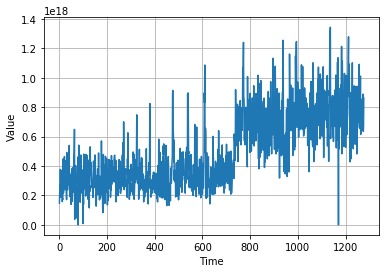

In [35]:
plot_series(time,series)


 Training Set


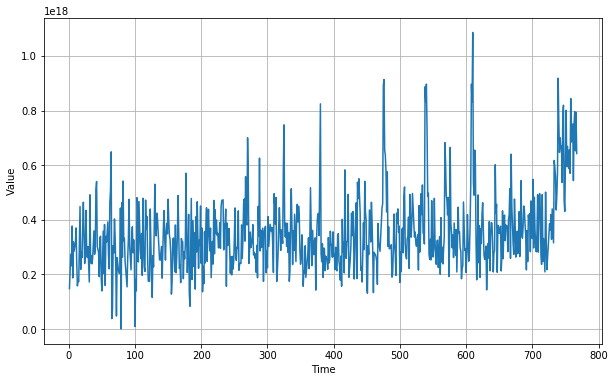


 Validation Set


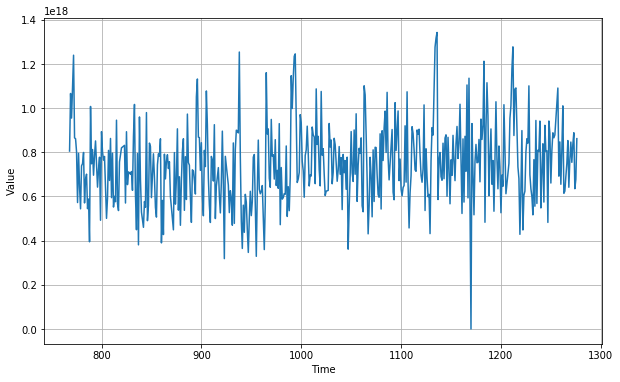

In [38]:
split_time = 365*2
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

print('\n Training Set')
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

print('\n Validation Set')
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [39]:
naive_forecast = series[split_time - 1:-1]


 Comparing validation with naive forecast


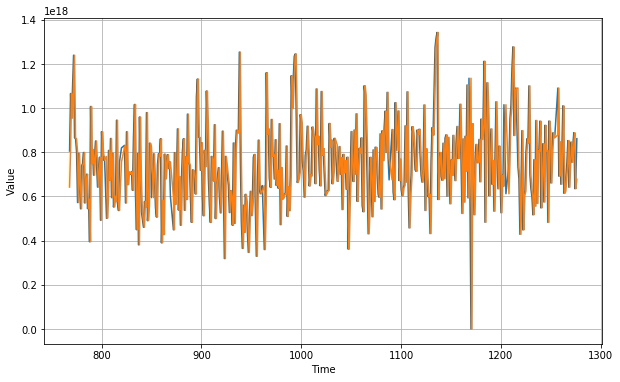

In [40]:
print('\n Comparing validation with naive forecast')
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

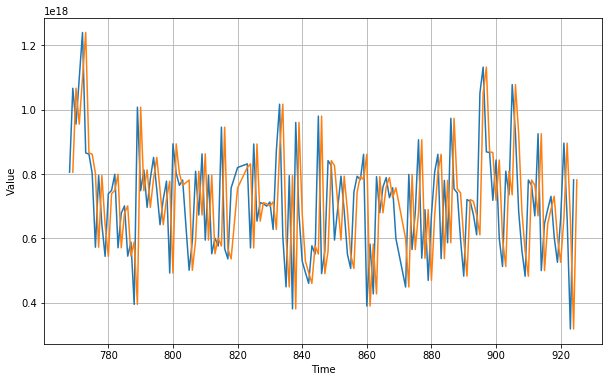

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [42]:
print('mean_squared_error: ',keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('mean_absolute_error:',keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

mean_squared_error:  5.137499261295277e+34
mean_absolute_error: 1.7683476672875235e+17


In [44]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

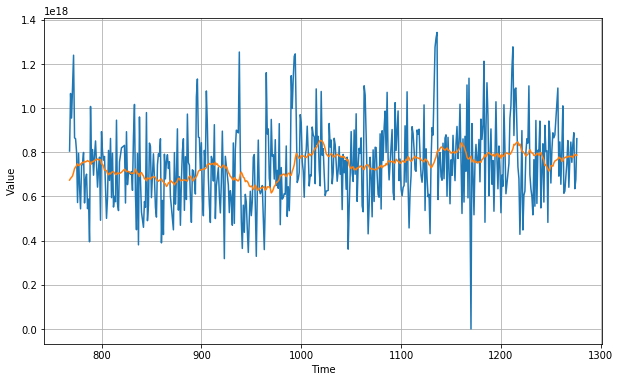

In [45]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [46]:
print('mean_squared_error',keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('mean_absolute_error',keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

mean_squared_error 3.2510760862039996e+34
mean_absolute_error 1.4151562228338992e+17


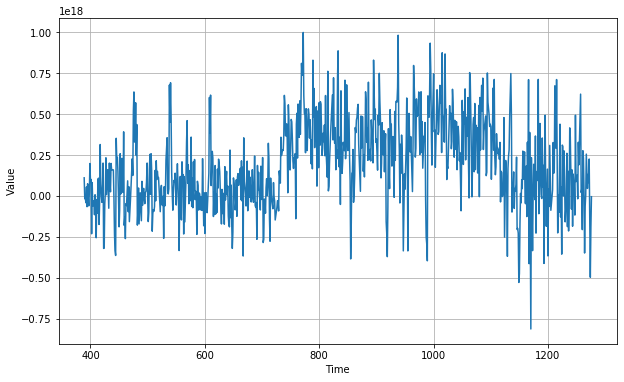

In [47]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

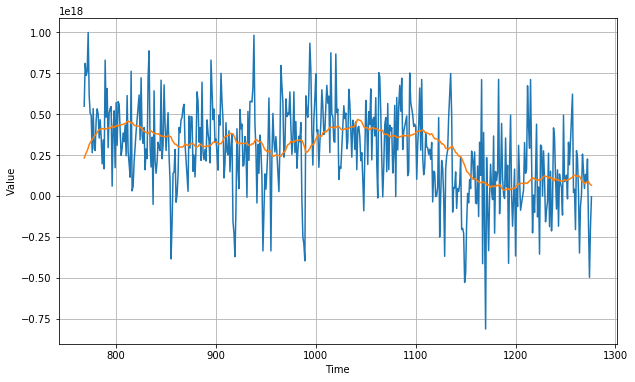

In [48]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

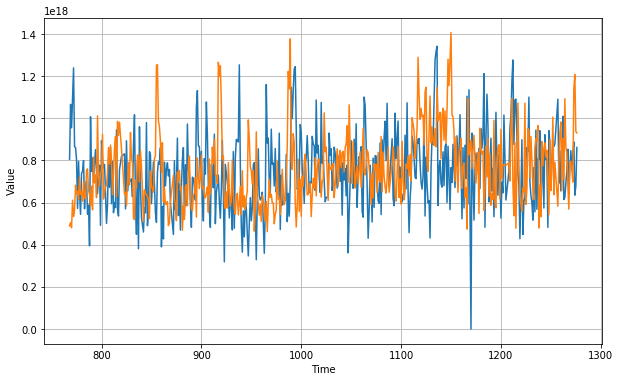

In [49]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [50]:
print('mean_squared_error',keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('mean_absolute_error',keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

mean_squared_error 6.369394319922875e+34
mean_absolute_error 1.9616902570561114e+17


This was a good example of professional 'improworsening' :). Still we've had the best result with the simple moving average. Even though that didn't consider seasonality.